# Homework 1. Likelihood-based models

- Task 1 (5 points): Warmup
- Task 2 (10 points): PixelCNN
- **Task 3 (10 points): Conditional PixelCNN**
- Task 4 (10 points): RealNVP
- \* Bonus (10+++ points)

## Task 3. Conditional PixelCNNs on Shapes and MNIST

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise). You may need `nn.Embedding` here

You can use a PixelCNN architecture similar to Task 2. Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes

Feel free to use and modify any sources from Task 2

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [3]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, cl_size, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        self.linear = nn.Linear(cl_size, self.out_channels)
    
    def forward(self, x, cl):
        cond_bias = self.linear(cl).view(cl.shape[0], self.out_channels, 1, 1)
        return F.conv2d(x, self.weight * self.mask, self.bias, padding=(self.kernel_size[0] // 2)) + cond_bias
        
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        half_k = k // 2 if k % 2 else k // 2 - 1
        self.mask[:, :, :half_k, :] = 1
        self.mask[:, :, half_k, :half_k] = 1
        if mask_type == 'B':
            self.mask[:, :, half_k, half_k] = 1

In [4]:
class MySequential(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

In [5]:
from re import X
class CondPixelCNN(nn.Module):
    def __init__(self, input_shape, n_classes, n_colors=2, n_filters=64,
               kernel_size=7, n_layers=5):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        
        self.input_shape = input_shape
        self.n_layers = n_layers
        self.n_colors = n_colors

        self.emb = nn.Embedding(n_classes, n_classes)

        self.blockA = MySequential(
            MaskedConv2D(n_classes, 'A', n_channels, n_filters, kernel_size=7),
            nn.ReLU()
        )
        self.blockB0 = MySequential(
            MaskedConv2D(n_classes, 'B', n_filters, n_filters, kernel_size=7),
            nn.ReLU()
        )
        self.blockB1 = MySequential(
            MaskedConv2D(n_classes, 'B', n_filters, n_filters, kernel_size=1),
            nn.ReLU()
        )
        self.last_mask = MaskedConv2D(n_classes, 'B', n_filters, self.n_colors * n_channels, kernel_size=1)
            
    def forward(self, x, cl):
        batch_size = x.shape[0]
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        cl = self.emb(cl)

        x = self.blockA(x, cl)

        for i in range(self.n_layers):
            x = self.blockB0(x, cl)

        x = self.blockB1(x, cl)

        return self.last_mask(x, cl)
        
    def loss(self, x, cl):
        return F.cross_entropy(self.forward(x, cl), x.long().squeeze(1))

    def sample(self, n, labels):
        samples = torch.zeros(n, *self.input_shape).float().to(device)
        labels = labels.long().to(device)
        with torch.no_grad():
            for row in range(self.input_shape[1]):
                for column in range(self.input_shape[2]):
                    logits = torch.zeros((n, self.n_colors))
                    logits[:, :] = self.forward(samples, labels)[:, :, row, column]
                    probs = F.softmax(logits, dim=1)
                    samples[:, :, row, column] = torch.multinomial(probs, 1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, y in train_loader:
        loss = model.loss(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            loss = model.loss(x, y)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, train_labels, test_data, test_labels, model, train_args={'epochs': 10, 'lr': 1e-3}):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    train_labels: A (n_train, 1) int64 numpy array or image labels with values in {0, 1, ..., num_classes - 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_labels: A (n_test, 1) int64 numpy array or image labels with values in {0, 1, ..., num_classes - 1}
    num_classes: int
    model: nn.Model item
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    train_data = torch.from_numpy(train_data.astype(float)).permute(0, 3, 1, 2).to(device)
    train_labels = torch.from_numpy(train_labels.astype(int)).to(device)
    train = list(zip(train_data, train_labels))

    test_data = torch.from_numpy(test_data.astype(float)).permute(0, 3, 1, 2).to(device)
    test_labels = torch.from_numpy(test_labels.astype(int)).to(device)
    test = list(zip(test_data, test_labels))

    train_loader = DataLoader(train, batch_size = 128, shuffle=True)
    test_loader = DataLoader(test, batch_size = 128, shuffle=True)

    model = model.to(device)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    return train_losses, test_losses, model

In [7]:
# For colab users: download data
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

--2022-03-18 15:58:17--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl [following]
--2022-03-18 15:58:17--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6108167 (5.8M) [application/octet-stream]
Saving to: ‘shapes.pkl.4’

shapes.pkl.4        100%[===================>]   5.83M  --.-KB/s    in 0.06s   

2022-03-18 15:58:18 (105 MB/s) - ‘shapes.pkl

### First dataset: **Shapes** (5 points)

In [8]:
shapes_train, shapes_test, shapes_labels_train, shapes_labels_test = \
    load_data('./shapes.pkl', include_labels=True)

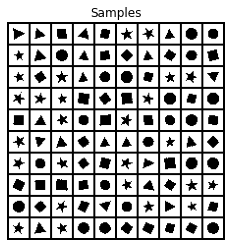

In [9]:
show_samples(shapes_train[:100])

In [10]:
num_classes = shapes_labels_train.max() + 1
num_classes

4

In [11]:
H, W, _ = shapes_train[0].shape
model = CondPixelCNN((1, H, W), num_classes).to(device)
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_labels_train, shapes_test, shapes_labels_test, model)

epoch 0 started
train loss: 0.2751110214285734, test_loss: 0.14315412938594818
epoch 1 started
train loss: 0.19844689729010187, test_loss: 0.11884591728448868
epoch 2 started
train loss: 0.1706263804581107, test_loss: 0.10764886438846588
epoch 3 started
train loss: 0.15402438271245578, test_loss: 0.09849090129137039
epoch 4 started
train loss: 0.1427092601795022, test_loss: 0.0974227637052536
epoch 5 started
train loss: 0.1345300289643247, test_loss: 0.08875260502099991
epoch 6 started
train loss: 0.1281158422681305, test_loss: 0.08595317602157593
epoch 7 started
train loss: 0.12273581157915475, test_loss: 0.08139728009700775
epoch 8 started
train loss: 0.11805807230716475, test_loss: 0.07610494643449783
epoch 9 started
train loss: 0.11380922621706636, test_loss: 0.07253128290176392


In [12]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

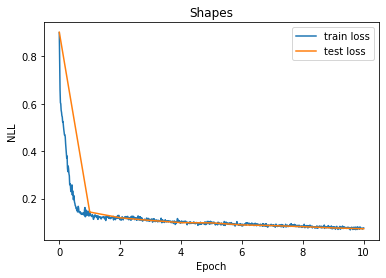

In [13]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [14]:
labels = [0] * 25 + [1] * 25 + [2] * 25 + [3] * 25

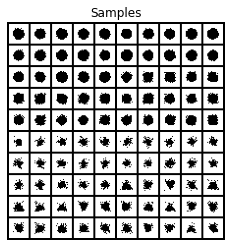

In [15]:
samples = shapes_model.sample(100, torch.tensor(labels, dtype=torch.long))
show_samples(samples)

### Second dataset: MNIST (5 points)

In [16]:
mnist_train, mnist_test, mnist_labels_train, mnist_labels_test = \
    load_data('./mnist.pkl', include_labels=True)

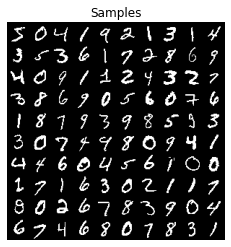

In [17]:
show_samples(mnist_train[:100])

In [18]:
num_classes = mnist_labels_train.max() + 1
num_classes

10

In [19]:
H, W, _ = mnist_train[0].shape
model = CondPixelCNN((1, H, W), num_classes).to(device)
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_labels_train, mnist_test, mnist_labels_test, model)

epoch 0 started
train loss: 0.1946687817192281, test_loss: 0.09085418283939362
epoch 1 started
train loss: 0.14076095904463898, test_loss: 0.08282440900802612
epoch 2 started
train loss: 0.08522388014197349, test_loss: 0.08030770719051361
epoch 3 started
train loss: 0.08168624781817198, test_loss: 0.07899171113967896
epoch 4 started
train loss: 0.07995572115480899, test_loss: 0.07908891141414642
epoch 5 started
train loss: 0.07876534924656153, test_loss: 0.07744947820901871
epoch 6 started
train loss: 0.07788014136254788, test_loss: 0.07664743810892105
epoch 7 started
train loss: 0.07715903274714947, test_loss: 0.07633767277002335
epoch 8 started
train loss: 0.07657923237234354, test_loss: 0.0756344124674797
epoch 9 started
train loss: 0.07607519643753767, test_loss: 0.07506612688302994


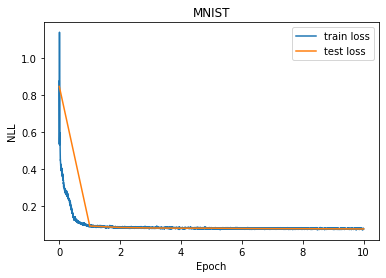

In [20]:
show_train_plots(train_losses, test_losses, 'MNIST')

In [21]:
labels = np.array(list(range(10)) * 10)

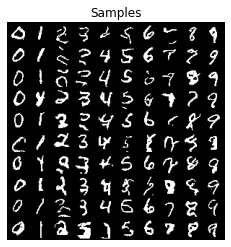

In [22]:
samples = mnist_model.sample(100, torch.tensor(labels, dtype=torch.long))
show_samples(samples)